## 多変量モデル

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, smape
from darts.models import NBEATSModel, RNNModel, TCNModel, TransformerModel
from darts.utils.timeseries_generation import (datetime_attribute_timeseries,
                                               gaussian_timeseries,
                                               linear_timeseries,
                                               sine_timeseries)

torch.manual_seed(1)
np.random.seed(1)  # for reproducibility

Importing plotly failed. Interactive plots will not work.


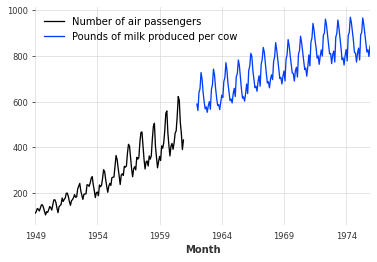

In [2]:
df_air = pd.read_csv("../data/AirPassengers.csv", delimiter=",")
series_air = TimeSeries.from_dataframe(df_air, "Month", ["#Passengers"])

df_milk = pd.read_csv("../data/monthly-milk.csv", delimiter=",")
series_milk = TimeSeries.from_dataframe(df_milk, "Month", ["Pounds per cow"])

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend()

#### Preprocessing

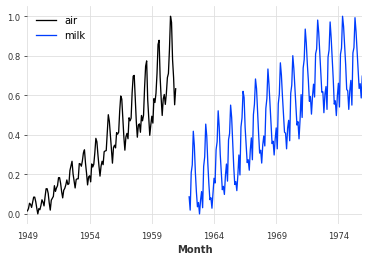

In [3]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

In [4]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

In [5]:
%%time

NBEATS_Model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=20)

NBEATS_Model.fit(train_air, verbose=True)

[2021-05-09 06:07:03,763] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.
[2021-05-09 06:07:03,763] INFO | darts.models.torch_forecasting_model | Train dataset contains 73 samples.


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 34.2 s, sys: 5.27 s, total: 39.5 s
Wall time: 1min 22s


MAPE = 13.28%


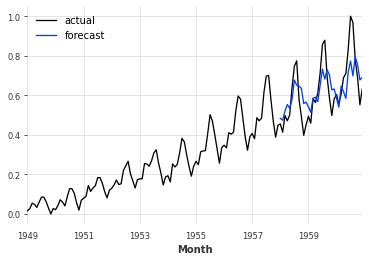

In [6]:
pred = NBEATS_Model.predict(n=36)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

#### Training on Both Air Traffic and Milk Series

In [7]:
%%time

Multi_NBEATS_Model = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=10
)

Multi_NBEATS_Model.fit([train_air, train_milk], verbose=True)

[2021-05-09 06:08:27,763] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.
[2021-05-09 06:08:27,763] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 39.4 s, sys: 2.95 s, total: 42.4 s
Wall time: 53.9 s


MAPE = 8.38%


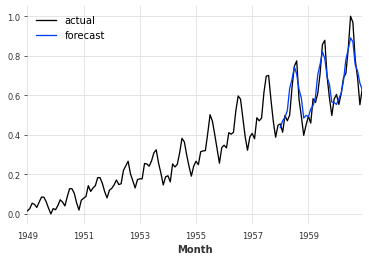

In [8]:
pred = Multi_NBEATS_Model.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

#### Training with Covariates

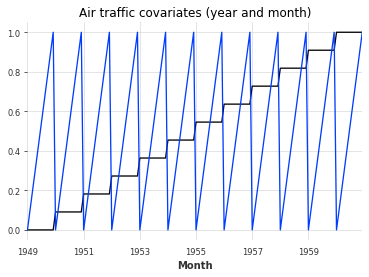

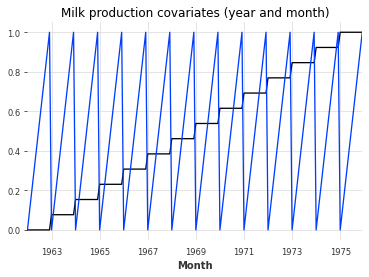

In [9]:
# build year and month series:
air_year = datetime_attribute_timeseries(series_air_scaled, attribute="year")
air_month = datetime_attribute_timeseries(series_air_scaled, attribute="month")

milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute="year")
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute="month")

# stack year and month to obtain series of 2 dimensions (year and month):
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# scale them between 0 and 1:
scaler_dt_air = Scaler()
air_covariates = scaler_dt_air.fit_transform(air_covariates)

scaler_dt_milk = Scaler()
milk_covariates = scaler_dt_milk.fit_transform(milk_covariates)

# split in train/validation sets:
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = (
    milk_covariates[:-36],
    milk_covariates[-36:],
)

# plot the covariates:
plt.figure()
air_covariates.plot()
plt.title("Air traffic covariates (year and month)")

plt.figure()
milk_covariates.plot()
plt.title("Milk production covariates (year and month)");

In [10]:
%%time

Multi_NBEATS_cov_Model = RNNModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=30
)

Multi_NBEATS_cov_Model.fit(
    series=[train_air, train_milk],
    covariates=[air_train_covariates, milk_train_covariates],
    verbose=True,
)

[2021-05-09 06:09:25,043] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.
[2021-05-09 06:09:25,043] INFO | darts.models.torch_forecasting_model | Train dataset contains 194 samples.


  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 3.58 s, sys: 503 ms, total: 4.08 s
Wall time: 6.73 s


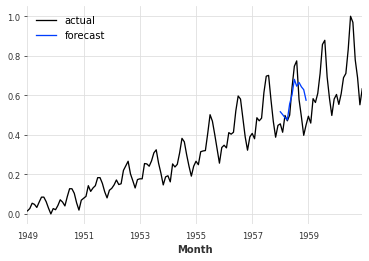

In [11]:
pred_cov = Multi_NBEATS_cov_Model.predict(
    n=12, series=train_air, covariates=air_train_covariates
)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend();

#### Backtesting with Covariates

  0%|          | 0/48 [00:00<?, ?it/s]

MAPE (using covariates) = 16.60%


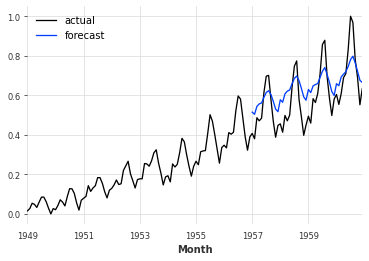

In [12]:
Multi_NBEATS_backtest_cov = Multi_NBEATS_cov_Model.historical_forecasts(
    series_air_scaled,
    covariates=air_covariates,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=True,
)

series_air_scaled.plot(label="actual")
Multi_NBEATS_backtest_cov.plot(label="forecast")
plt.legend()
print(
    "MAPE (using covariates) = {:.2f}%".format(
        mape(series_air_scaled, Multi_NBEATS_backtest_cov)
    )
)